# Node Embeddings of Disease Graph | Stellargraph Unsupervised

Here, we shall have a disease graph consisting of ICD10 codes as nodes (instead of the HCC codes as nodes), and assign these nodes their HCC codes as labels. Therefore, we shall have 10k+ nodes having 83 labels. Our task shall then be supervised. This ought to help us learn better node embeddings than the unsupervised task.

NOTE: Since there can be multiple HCCs tagged for a single ICD-10 code, the task will be multi-label classification.

***Links***
* Loading data in Stellargraph objects from Pandas - https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
* Algorithms for Task - https://stellargraph.readthedocs.io/en/v1.2.0/demos/index.html
* Node Classification with Directed GraphSAGE - https://stellargraph.readthedocs.io/en/v1.2.0/demos/node-classification/directed-graphsage-node-classification.html
* Unsupervised Representation Learning - https://stellargraph.readthedocs.io/en/stable/demos/embeddings/index.html#find-algorithms-and-demos-for-a-graph
* Unsupervised GraphSAGE & UnsupervisedSampler - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html
* Unsupervised DeepGraphInfoMax - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/deep-graph-infomax-embeddings.html
* Data Generators | Stellargraph - https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.mapper.CorruptedGenerator
* Creating multiple checkboxes in IPyWidgets - https://stackoverflow.com/questions/57219796/ipywidgets-dynamic-creation-of-checkboxes-and-selection-of-data
* 


In [378]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
import ipywidgets as widgets

import networkx as nx
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph.data import UnsupervisedSampler
from stellargraph import StellarGraph, StellarDiGraph, datasets, utils
from stellargraph.layer import GraphSAGE, DirectedGraphSAGE, link_classification , DeepGraphInfomax, GCN
from stellargraph.mapper import DirectedGraphSAGELinkGenerator, GraphSAGELinkGenerator, GraphSAGENodeGenerator, CorruptedGenerator, FullBatchNodeGenerator


import warnings
from time import time
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

In [3]:
# constants
metadata_columns = ['Diagnosis Code','Description','CMS-HCC Model Category V24']
inpatient_data_columns = ['empi','visit_id','visit_start_date','primary_diagnosis']
outpatient_data_columns = ['empi','visit_id','last_date_of_service','primary_diagnosis']

# file paths
metadata_fp = "/workspaces/graphs/graphs-eda/data/metadata/2022 Midyear_Final ICD-10-CM Mappings.csv"
inpatient_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_preprocessed.csv"
outpatient_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_outpatient.csv"

In [53]:
def prepare_metadata(metadata_fp):
    """
    Reads, cleans and prepares the HCC metadata file
    """
    # reading the risk adjustment metadata file
    metadata = pd.read_csv(metadata_fp)

    # cleaning the risk adjustment metadata file
    metadata = metadata.iloc[2:-7,:]
    metadata.replace(r'\n',' ', regex=True, inplace=True)
    metadata.reset_index(drop=True, inplace=True)

    # creating the cleaned risk adjustment metadata dataframe
    new_metadata = pd.DataFrame(metadata.iloc[1:,:])
    new_metadata.columns = metadata.iloc[0,:].tolist()

    # filtering only the required columns from patient data and metadata
    new_metadata = new_metadata.loc[:,metadata_columns]
    new_metadata.columns = ['pd','dscr','hcc']
    new_metadata.loc[:,"hcc"] = new_metadata.hcc.fillna(0).astype('int')

    return new_metadata


def prepare_patient_data(inpatient_data_fp, outpatient_data_fp):
    """
    Reads and filters only the required columns from inpatient and outpatient data
    """
    # reading the inpatient and outpatient data 
    inpatient_data = pd.read_csv(inpatient_data_fp)
    outpatient_data = pd.read_csv(outpatient_data_fp)

    inpatient_data = inpatient_data.loc[:,inpatient_data_columns]
    outpatient_data = outpatient_data.loc[:,outpatient_data_columns]

    inpatient_data.columns = ['empi','vid','vdt','pd']
    outpatient_data.columns = ['empi','vid','vdt','pd']

    return inpatient_data, outpatient_data


def create_edge_table(data):
    """creates edge-table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = data.sort_values(['empi','vdt']).reset_index(drop=True)
    data["pd_nxt"] = data.pd.shift(-1)
    index_drop = data.groupby('empi').tail(1).index
    data = data.drop(index_drop)
    data = data[data.pd!=data.pd_nxt].reset_index(drop=True)

    data['edge'] = data.pd + ", " + data.pd_nxt
    data['cnt'] = 1

    edge_data = data.groupby(['pd','pd_nxt'], as_index=False).agg({'cnt':'count'})
    edge_data.columns = ['source','target','weight']

    return edge_data


def create_node_table(data):
    """Creates node table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    node_data = pd.DataFrame(data.pd.unique(), columns=['pd'])
    node_data.index = node_data.pd
    node_data.pd = 1
    return node_data


def remove_sparse_nodes(node_data, edge_data, n):
    """Removes edges having weight less than n 
    and then removes nodes having no edges connected
    to them
    """
    edge_data = edge_data[edge_data.weight>=n].reset_index(drop=True)
    filter1 = node_data.index.isin(edge_data.source.unique())
    filter2 = node_data.index.isin(edge_data.target.unique())
    node_data = node_data[filter1 | filter2]
    return node_data, edge_data


def create_stellargraph(node_data, edge_data):

    G = StellarDiGraph({"node":node_data}, {"edge":edge_data})
    return G

def create_node_features(node_data, edge_data):
    """Create node features

    Args:
        node_data (_type_): _description_
        edge_data (_type_): _description_
    """
    Gd = create_stellargraph(node_data, edge_data).to_networkx()
    Gu = StellarGraph(node_data, edge_data).to_networkx()
    node_features_dict = {}

    node_features_dict["in_degree_centrality"] = nx.in_degree_centrality(Gd)
    print("in_degree_centrality computed")
    node_features_dict["out_degree_centrality"] = nx.out_degree_centrality(Gd)
    print("out_degree_centrality computed")
    node_features_dict["load_centrality"] = nx.load_centrality(Gd)
    print("load_centrality computed")
    node_features_dict["eigenvector_centrality_numpy"] = nx.eigenvector_centrality_numpy(Gd)
    print("eigenvector_centrality_numpy computed")
    node_features_dict["closeness_centrality"] = nx.closeness_centrality(Gd)
    print("closeness_centrality computed")
    # node_features_dict["current_flow_closeness_centrality"] = nx.current_flow_closeness_centrality(Gu)
    # print("current_flow_closeness_centrality computed")
    # node_features_dict["information_centrality"] = nx.information_centrality(Gu)
    # print("information_centrality computed")
    node_features_dict["betweenness_centrality_source"] = nx.betweenness_centrality_source(Gd)
    print("betweenness_centrality_source computed")
    # node_features_dict["current_flow_betweenness_centrality"] = nx.current_flow_betweenness_centrality(Gu)
    # print("current_flow_betweenness_centrality computed")
    # node_features_dict["approximate_current_flow_betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(Gu)
    # print("approximate_current_flow_betweenness_centrality computed")
    node_features_dict["harmonic_centrality"] = nx.harmonic_centrality(Gd)
    print("harmonic_centrality computed")
    # node_features_dict["second_order_centrality"] = nx.second_order_centrality(Gu)
    # print("second_order_centrality computed")
    node_features_dict["pagerank"] = nx.pagerank_numpy(Gd)
    print("pagerank computed")
    node_features_dict["average_neighbor_degree"] = nx.average_neighbor_degree(Gd)
    print("average_neighbor_degree computed")
    node_features_dict["node_clique_number"] = nx.node_clique_number(Gu)
    print("node_clique_number computed")
    node_features_dict["hits_numpy"] = nx.hits_numpy(Gd)[0]
    print("hits_numpy computed")
    # node_features_dict["triangles"] = nx.triangles(G)
    # print("triangles computed")
    # node_features_dict["square_clustering"] = nx.square_clustering(Gd)
    # print("square_clustering computed")

    data = pd.DataFrame({'in_degree_centrality':pd.Series(node_features_dict['in_degree_centrality'])})
    for key, value in node_features_dict.items():
        data[key] = pd.Series(value)
    return data


def filter_edge_data_by_node(node, edge_data):
    n_i = edge_data.columns[0]
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_i]==node
    filter2 = edge_data[n_j]==node
    return edge_data[filter1 | filter2].sort_values(weight)


def filter_edge_data_by_source_node(node, edge_data):

    filter1 = edge_data.source==node
    return edge_data[filter1].sort_values('weight')


def filter_edge_data_by_target_node(node, edge_data):
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_j]==node
    return edge_data[filter1].sort_values(weight)

In [61]:
# preparing cleaned risk adjustment metadata
metadata = prepare_metadata(metadata_fp)

# filtering only the required columns from inpatient and outpatient data
inpatient_data, outpatient_data = prepare_patient_data(inpatient_data_fp, outpatient_data_fp)

In [366]:
data_combined = pd.concat([inpatient_data, outpatient_data], axis=0)
edge_data = create_edge_table(data_combined)
node_data = create_node_table(data_combined)

In [367]:
print(f"Graph info before removing sparse nodes\n{create_stellargraph(node_data, edge_data).info()}")
node_data, edge_data = remove_sparse_nodes(node_data, edge_data, 5)
G = create_stellargraph(node_data, edge_data)
print(f"\nGraph info after removing sparse nodes\n{G.info()}")

Graph info before removing sparse nodes
StellarDiGraph: Directed multigraph
 Nodes: 7095, Edges: 94165

 Node types:
  node: [7095]
    Features: float32 vector, length 1
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [94165]
        Weights: range=[1, 342], mean=1.72311, std=4.09551
        Features: none

Graph info after removing sparse nodes
StellarDiGraph: Directed multigraph
 Nodes: 699, Edges: 4188

 Node types:
  node: [699]
    Features: float32 vector, length 1
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [4188]
        Weights: range=[5, 342], mean=11.8281, std=16.1884
        Features: none


In [368]:
nodes = list(G.nodes())
number_of_walks = 5
length = 4

In [369]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [370]:
batch_size = 50
epochs = 4
in_samples = [10, 5]
out_samples = [10, 5]

In [371]:
generator = GraphSAGELinkGenerator(G, batch_size, in_samples)
train_gen = generator.flow(unsupervised_samples)

In [372]:
layer_sizes = [32, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [373]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [374]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [375]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
420/420 [==============================] - 51s 118ms/step - loss: 0.8133 - binary_accuracy: 0.5000
Epoch 2/4
420/420 [==============================] - 48s 113ms/step - loss: 0.8133 - binary_accuracy: 0.5000
Epoch 3/4
420/420 [==============================] - 52s 123ms/step - loss: 0.8133 - binary_accuracy: 0.5000
Epoch 4/4
420/420 [==============================] - 49s 117ms/step - loss: 0.8133 - binary_accuracy: 0.5000


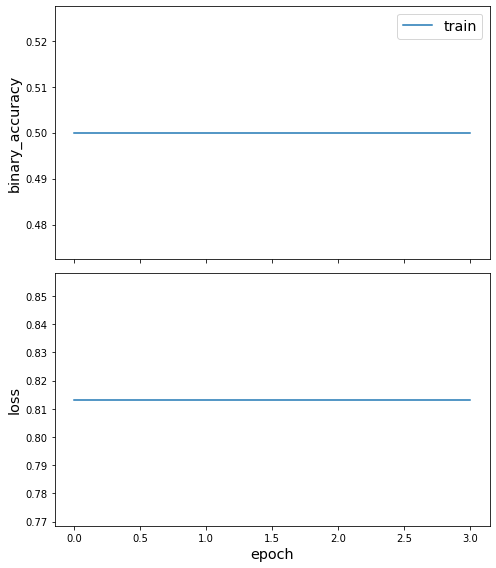

In [379]:
utils.plot_history(history)

In [16]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [17]:
node_ids = node_data.index
node_gen = GraphSAGENodeGenerator(G, batch_size, in_samples).flow(node_ids)

In [18]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

14/14 [==============================] - 1s 55ms/step


In [19]:
X.shape

NameError: name 'X' is not defined

In [ ]:
node_subject = np.arange(0,node_data.shape[0])

X = node_embeddings
transform = TSNE  # PCA

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
emb_transformed["label"] = node_ids

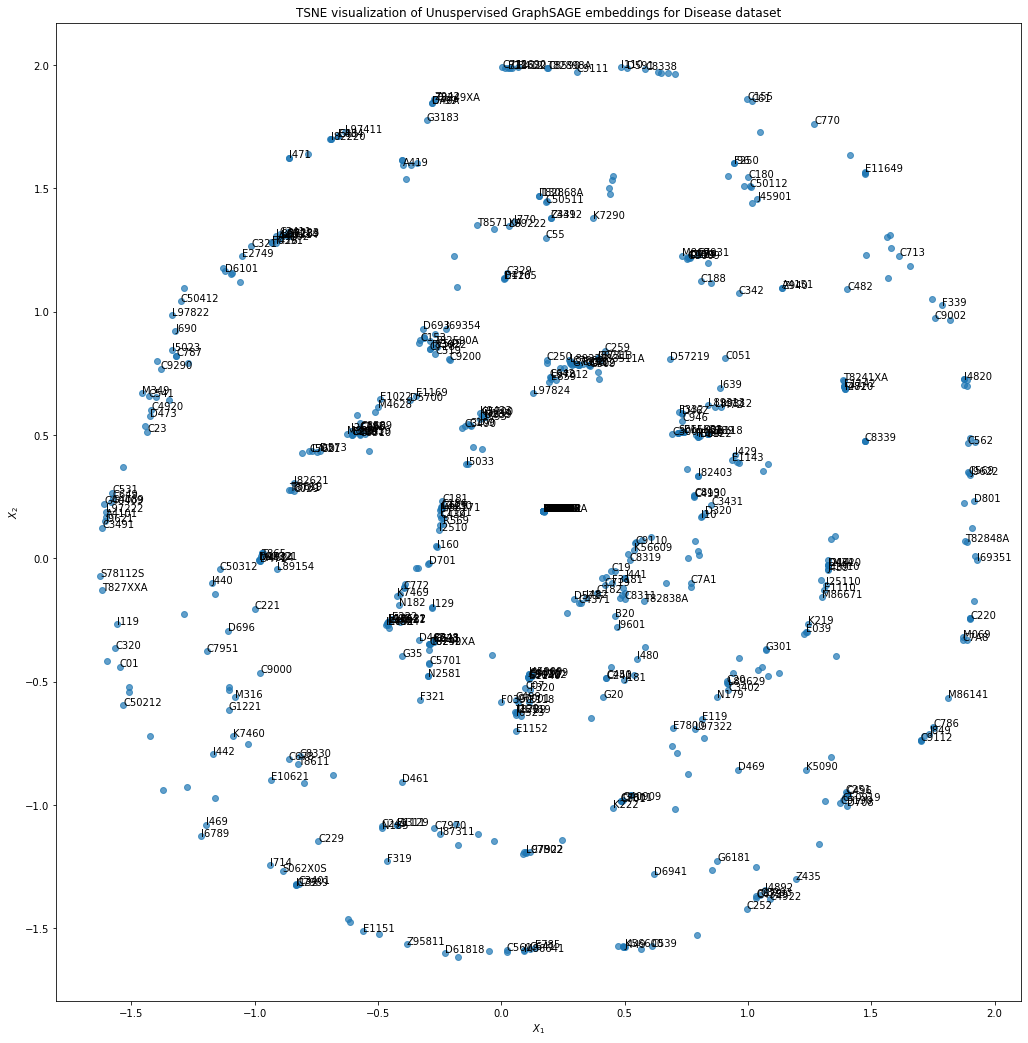

In [ ]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    # c=emb_transformed["label"],
    # cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} ICD-10 Disease Embeddings Unusupervised GraphSAGE without Node Features".format(transform.__name__)
)
for i, row in emb_transformed.iterrows():
    sum_ = metadata.pd.str.contains(row['label']).sum()
    if sum_>0:
        plt.annotate(row['label'], (row[0],row[1]))
plt.show()

### Observations:
* Loss function fails to converge
* Embeddings vreated are random
* Unsupervised learning on ICD-10 codes as nodes without features doesn't are not expressive

### Unsupervised Disease EMbeddings with Node Features

In [380]:
node_features = create_node_features(node_data, edge_data)

in_degree_centrality computed
out_degree_centrality computed
load_centrality computed
eigenvector_centrality_numpy computed
closeness_centrality computed
betweenness_centrality_source computed
harmonic_centrality computed
pagerank computed
average_neighbor_degree computed
node_clique_number computed
hits_numpy computed


<AxesSubplot:>

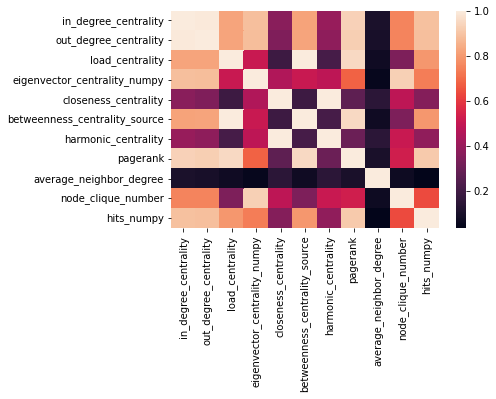

In [381]:
sns.heatmap(node_features.corr().abs())

In [382]:
node_data_x = node_data.copy()

In [383]:
node_data_x = pd.concat([node_data_x,node_features], axis=1).drop('pd', axis=1)

In [384]:
Gx = create_stellargraph(node_data_x, edge_data)
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 699, Edges: 4188

 Node types:
  node: [699]
    Features: float32 vector, length 1
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [4188]
        Weights: range=[5, 342], mean=11.8281, std=16.1884
        Features: none


In [385]:
nodes = list(Gx.nodes())
number_of_walks = 5
length = 4
batch_size = 50
epochs = 10
in_samples = [10, 5]
out_samples = [10, 5]

In [386]:
unsupervised_samples = UnsupervisedSampler(
    Gx, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [387]:
generator = GraphSAGELinkGenerator(Gx, batch_size, in_samples)
train_gen = generator.flow(unsupervised_samples)

In [388]:
layer_sizes = [32, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [389]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [390]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [391]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/10
420/420 [==============================] - 55s 129ms/step - loss: 0.7189 - binary_accuracy: 0.5382
Epoch 2/10
420/420 [==============================] - 47s 112ms/step - loss: 0.6628 - binary_accuracy: 0.5993
Epoch 3/10
420/420 [==============================] - 47s 111ms/step - loss: 0.6458 - binary_accuracy: 0.6299
Epoch 4/10
420/420 [==============================] - 51s 120ms/step - loss: 0.6368 - binary_accuracy: 0.6473
Epoch 5/10
420/420 [==============================] - 55s 130ms/step - loss: 0.6316 - binary_accuracy: 0.6587
Epoch 6/10
420/420 [==============================] - 63s 150ms/step - loss: 0.6302 - binary_accuracy: 0.6574
Epoch 7/10
420/420 [==============================] - 72s 171ms/step - loss: 0.6267 - binary_accuracy: 0.6638
Epoch 8/10
420/420 [==============================] - 64s 150ms/step - loss: 0.6290 - binary_accuracy: 0.6590
Epoch 9/10
420/420 [==============================] - 53s 126ms/step - loss: 0.6247 - binary_accuracy: 0.6681
Epoch 10/1

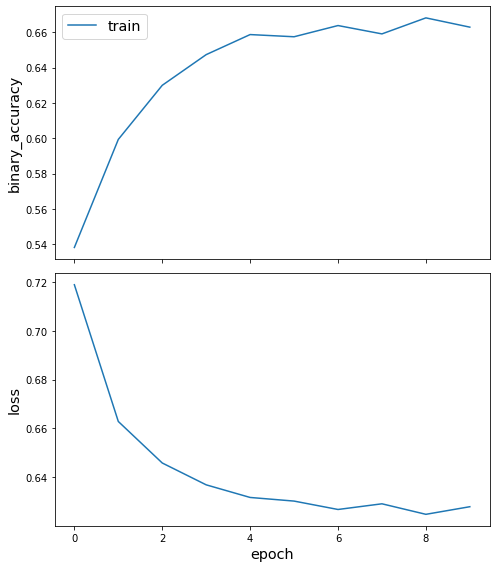

In [392]:
utils.plot_history(history)

In [393]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [394]:
node_ids = node_data.index
node_gen = GraphSAGENodeGenerator(Gx, batch_size, in_samples).flow(node_ids)

In [395]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

14/14 [==============================] - 1s 50ms/step


In [433]:
node_subject = np.arange(0,node_data.shape[0])

X = node_embeddings
transform = TSNE  # PCA

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
emb_transformed["label"] = node_ids

In [434]:
# cancer 8, 9, 10, 11, 12
# 51, 52, 57, 59 [dementia, schizophrenia, depression]
# 84,85,86,87,88,96,100 [heart diseases]
# 134, 135, 136, 137 [Dialysis, Acute Renal failure, CKD]
# 157, 158, 159, 161 [Ulcers]
# 176, 186, 188, 189 [artifical opening, organ transplant, surgery, amputation]
# mixed 108, 161

In [435]:
emb_transformed_hcc = emb_transformed.merge(metadata[['pd','hcc']], on='pd', how='left').fillna(0.0)
emb_transformed_hcc = emb_transformed_hcc[emb_transformed_hcc.hcc!=0]

In [436]:
data = emb_transformed_hcc.hcc.sort_values().unique().tolist()
checkboxes = [widgets.Checkbox(value=False, description=str(label)) for label in data]
output = widgets.VBox(children=checkboxes)
# display(output)

In [1]:
HBox([
    VBox(checkboxes[:10]),
    VBox(checkboxes[10:20]),
    VBox(checkboxes[20:30]),
    VBox(checkboxes[30:40]),
    VBox(checkboxes[40:50]),
    VBox(checkboxes[50:])
])

NameError: name 'HBox' is not defined

In [493]:
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
selected_data = [float(i) for i in selected_data]
print(selected_data)

[17.0, 18.0, 19.0]


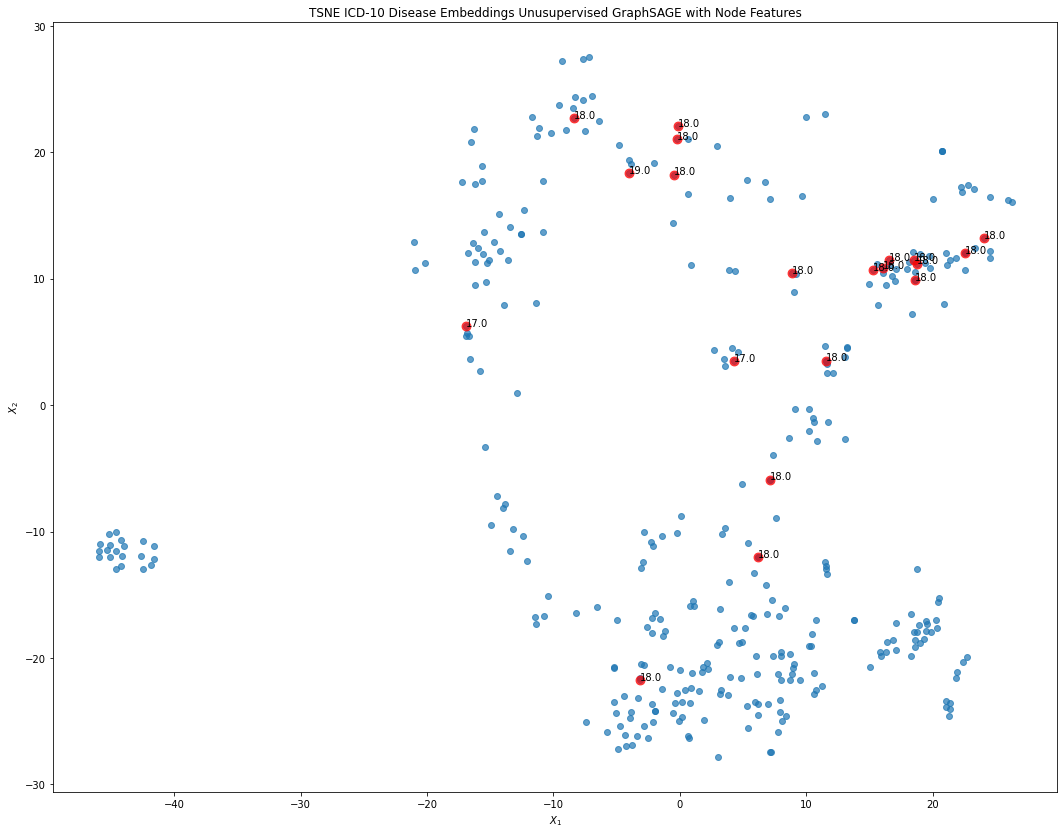

In [494]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(
    emb_transformed_hcc[0],
    emb_transformed_hcc[1],
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} ICD-10 Disease Embeddings Unusupervised GraphSAGE with Node Features".format(transform.__name__)
)
selected_data_embeddings = emb_transformed_hcc[emb_transformed_hcc.hcc.isin(selected_data)]
for i, row in selected_data_embeddings.iterrows():
    plt.annotate(row['hcc'], (row[0],row[1]))
    ax.scatter(
    row[0],
    row[1],
    c='red',
    s=80,
    alpha=alpha,
    )
plt.show()

### Observations
* On including node features, much more expressive feature embeddings are observed
* ICD diagnosis codes belinging to certain HCC codes are located near to each other, indicating that the latent relationships between the diseases is captured to some extent
* For example - 
    - primary diagnosis related to cancer HCCs (8-12) are clustered in the right
    - primary diagnosis related to heart diseases are clusteredon the left flank

***Next Steps***
* Any more disease (node) features to improve expressiveness that can be included?
* Assign HCC labels to disease nodes (node labels) to perform supervised learning
* Interactive visualisation (hovering the cursor over a node should show its ICD10 and HCC code)

2         I110
3        E1169
8        I4891
10        N179
12      I25110
        ...   
711    S78112S
712       D573
713       D593
714      C8293
715       C188
Name: label, Length: 360, dtype: object

In [473]:
data_combined[data_combined.pd.isin(emb_transformed_hcc.label.unique())].shape[0]/data_combined.shape[0]

0.3641227772922649

In [497]:
emb_transformed_hcc

,pd,0,1,label,hcc
2,I110,-6.424108,22.502644,I110,85.0
3,E1169,-3.176073,-21.753387,E1169,18.0
8,I4891,-4.062913,19.406502,I4891,96.0
10,N179,-3.829575,19.033424,N179,135.0
12,I25110,2.952773,20.492275,I25110,87.0
...,...,...,...,...,...
711,S78112S,15.587469,11.131359,S78112S,189.0
712,D573,16.270357,9.516446,D573,48.0
713,D593,24.549362,11.667969,D593,46.0
714,C8293,21.837557,-21.581053,C8293,10.0
